In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
NB_EPOCH = 100
TIME_LIM = None # 25
BATCH_SIZE = 64

REPEAT_TIMES = 10

In [4]:
def make_2d_classification(N=4000, well_split=True):
    a_pos1 = torch.randn(N//4, 2) + torch.tensor([3.0, 2.0])
    a_pos2 = torch.randn(N//4, 2) + torch.tensor([-3.0, 3.0])
    if well_split:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -5.0])
    else:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -2.0])
    data = torch.cat([a_pos1, a_pos2, a_neg], dim=0)
    data = (data - data.mean(axis=0)) / np.sqrt(data.var(axis=0))
    labels = torch.cat([torch.ones(N//2), torch.zeros(N//2)])
    return TensorDataset(data, labels)

In [5]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [6]:
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    # filtered_data = (data[mask] / 255).float()
    
    scaler = StandardScaler()
    filtered_data = torch.from_numpy(scaler.fit_transform(data[mask])).float()

    # filtered_data = (filtered_data - filtered_data.mean(axis=0)) / np.sqrt(filtered_data.var(axis=0))

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [7]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
# mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [8]:
import pandas as pd

def read_csv_reg(filename, sep=";"):
    df = pd.read_csv(filename, sep=sep)
    X = torch.from_numpy(df.iloc[:, :-1].values).float()
    y = torch.from_numpy(df.iloc[:, -1].values).float()
    return TensorDataset(X, y)

In [9]:
from sklearn.datasets import make_blobs

# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5

def blob_dataset():
    clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                                n_features=DATASET_DIM,
                                centers=DATASET_CLUSTER_COUNT,
                                #random_state=42
                                )

    data = torch.from_numpy(clustered_data.astype(np.float32))
    labels = torch.zeros(DATASET_SIZE)
    return TensorDataset(data, labels)

In [10]:
from cluster_tools import kmeans_elbow_aux, ClusterSampler, logistic_label_01_process, no_process

Samplers

In [11]:
LAMBDA = 1e-4 # L2 regularization

class SimpleModel(nn.Module):
    def __init__(self, dataset): #bias=True):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1)#, bias=bias)
        self.layer.weight.data.fill_(0)
        # if bias:
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        return self.layer(ai)

def least_squares_crit(ax, b):
    return (1/2*((ax.flatten() - b)**2)).mean()

def log_01_criterion(pred, labels):
    l = labels.view(-1, 1)*2 - 1
    return (nn.functional.softplus(-l*pred)).mean()

In [12]:
from sklearn.datasets import load_svmlight_file
import warnings

def load_svm_classif_tensor(filename, process=None):
    X, y = load_svmlight_file(filename)
    X = torch.tensor(X.toarray(), dtype=torch.float32)

    scaler = StandardScaler()
    scaled_X = torch.from_numpy(scaler.fit_transform(X)).float()

    y = torch.tensor(y, dtype=torch.int32)
    if process is not None: # converts the other possible label types to 0/1
        if process == "1 2":
            y -= 1
        elif process == "+-1":
            y = (y + 1)/2
        else:
            warnings.warn("process should be one of '1 2' or '+-1'", UserWarning)
    return TensorDataset(scaled_X, y)

In [13]:
dataset = load_svm_classif_tensor("./data/phishing_dataset.txt") 
#read_csv_reg("./data/winequality-white.csv")
#make_2d_classification(well_split=True) 
#load_svm_classif_tensor("./data/phishing_dataset.txt") 
clustered_data, full_labels = dataset.tensors
labeled_data = logistic_label_01_process(dataset)
N, DIM = clustered_data.shape

In [14]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="pca")

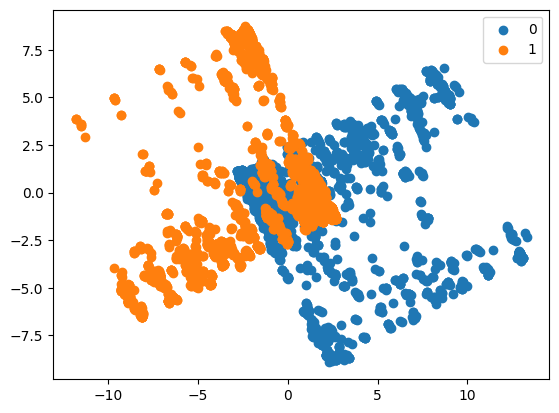

In [15]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (full_labels == 0)
mask_1 = (full_labels == 1)
plt.scatter(compressed_labeled[mask_0,0], compressed_labeled[mask_0,1], label="0")
plt.scatter(compressed_labeled[mask_1,0], compressed_labeled[mask_1,1], label="1")
plt.legend()
plt.show()

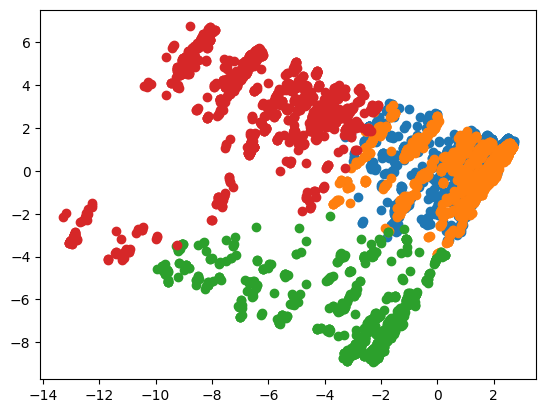

In [16]:
from cluster_tools import get_clusters

kmeans_clusters = get_clusters(dataset)#, logistic_label_01_process)

cluster_sampler = ClusterSampler(N, BATCH_SIZE, kmeans_clusters)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    try:
        plt.scatter(selected[:,0], selected[:,1])
    except:
        print(selected)
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

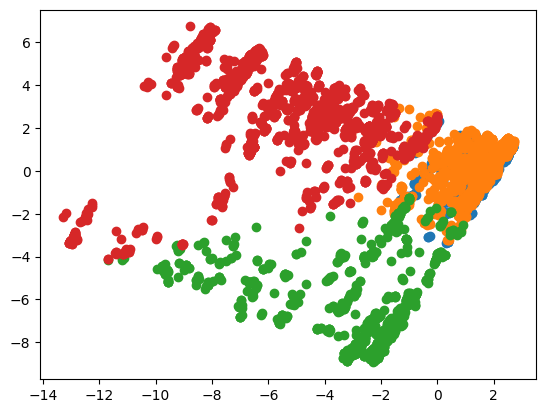

In [17]:
from cluster_tools import kmeans_cos_elbow

cos_clusters = get_clusters(dataset, clustering_method=kmeans_cos_elbow)
cosine_cluster_sampler = ClusterSampler(N, BATCH_SIZE, cos_clusters)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [59]:
def get_grad(batch, labels, model, criterion=log_01_criterion):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [19]:
# A = clustered_data
# b = full_labels

# opt_weights = torch.from_numpy(
#     np.linalg.solve(A.T@A + LAMBDA*np.eye(DIM,dtype=np.float32), 
#                     A.T@b))
# opt_weights

In [20]:
# opt_val = (least_squares_crit(A@opt_weights, b) \
#     + LAMBDA/2*(opt_weights**2).sum()).item()
# opt_val

In [21]:
# finding an exact solution

from tqdm import tqdm
from solvers import get_regularized_loss

model = SimpleModel(clustered_data) #bias=False)

def train_model_until(model, 
                      data, 
                      labels, 
                      criterion, 
                      err, 
                      lr=2, 
                      opt_val=None, 
                      display_interval=1000):
    curr_epoch = 0
    regularized_ls = []

    while 1:
        reg_loss = get_regularized_loss(model, 
                                        data, 
                                        labels, 
                                        criterion,
                                        LAMBDA)
        model.zero_grad()
        reg_loss.backward()
        for p in model.parameters():
            p.data.sub_(lr*(p.grad.data))
        regularized_ls.append(reg_loss.item())
        curr_epoch += 1
        if curr_epoch % display_interval == 0:
            print(curr_epoch, reg_loss.item())
        if curr_epoch > 1:
            if opt_val is None and regularized_ls[-2] - regularized_ls[-1] < err:
                break
            if opt_val is not None and regularized_ls[-1] - opt_val < err:
                break
    return curr_epoch, regularized_ls

curr_epoch, regularized_ls = train_model_until(model, 
                                               clustered_data, 
                                               full_labels, 
                                               log_01_criterion,
                                               1e-11)
                                               #least_squares_crit,
                                               #1e-8, 
                                               #lr=8e-5, 
                                               #opt_val=opt_val, 
                                               #display_interval=1000)
# with torch.no_grad():
    # model.layer.weight.copy_(opt_weights)
# opt_val = min(opt_val, min(regularized_ls)) # regularized_ls[-1] 
opt_val = min(regularized_ls)
print(curr_epoch, opt_val)

670 0.14230386912822723


In [ ]:
output = model(clustered_data)
model.zero_grad()
loss = log_01_criterion(output, full_labels)
print(loss)
loss.backward()
for p in model.parameters():
    print(p.grad.data + LAMBDA*p.data)
    print(p.data)

tensor(18.3128, grad_fn=<MeanBackward0>)
tensor([[-6.5484e-01,  5.1259e-01, -4.7761e-01,  3.0231e-01,  3.8532e-01,
         -3.7811e+00, -8.1859e-01, -3.1955e+00,  1.5389e+00, -5.4080e-02,
          1.4406e-01,  4.0279e-01,  1.6935e+00, -4.7631e+00,  1.0831e+00,
         -1.3316e+00,  5.6780e-04,  4.6446e-01,  1.2333e-01,  2.5297e-01,
          7.8368e-03, -4.1856e-02, -1.5132e-01, -6.6974e-01, -4.9881e-01,
         -1.2337e+00, -5.9696e-01,  8.8902e-01,  5.3682e-01, -4.6574e-01,
          6.5484e-01, -3.8532e-01, -1.7830e+00,  4.6866e+00,  1.7579e+00,
         -1.5947e+00, -5.6780e-04, -4.6446e-01, -1.8915e+00,  4.6574e-01,
         -2.3544e-01,  6.6974e-01,  2.6558e+00, -6.5845e-01, -1.5389e+00,
         -1.6935e+00,  6.1595e-01,  2.9868e-01,  4.7761e-01,  2.5159e+00,
         -4.0279e-01, -2.5297e-01,  4.1856e-02,  4.9881e-01,  5.9696e-01,
         -2.6870e+00,  3.7811e+00,  1.3477e+00, -4.3353e-01, -3.0231e-01,
         -1.4406e-01, -7.8368e-03,  1.5132e-01,  3.1310e+00, -1.2333e-0

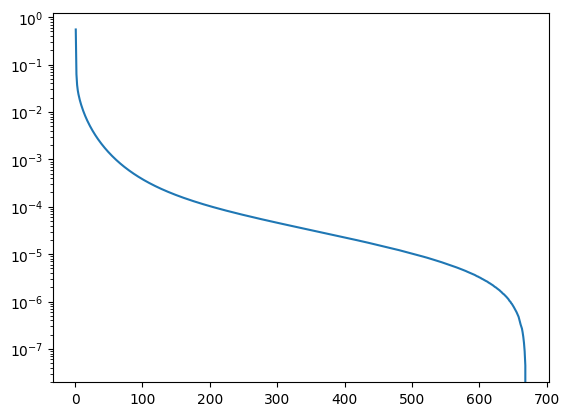

In [23]:
plt.plot(np.arange(1, len(regularized_ls)+1), np.array(regularized_ls)-opt_val)
plt.yscale("log")
# plt.loglog()
plt.show()

Getting gradients closer to the objective, testing out if reclustering could in theory work

In [73]:
from cluster_tools import kmeans_pp_elbow

close_model = SimpleModel(clustered_data) #bias=True)
_ = train_model_until(close_model, 
                      clustered_data, 
                      full_labels,
                      log_01_criterion,
                      1e-4,)
close_cluster_labels = kmeans_pp_elbow(get_grad(clustered_data, full_labels, close_model))
new_cluster_sampler = ClusterSampler(N, BATCH_SIZE, close_cluster_labels)

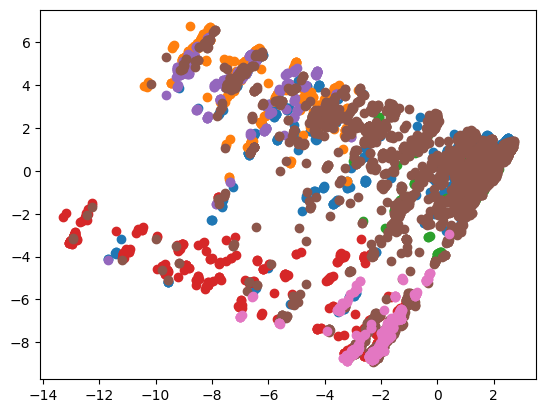

In [25]:
for i in range(new_cluster_sampler.cluster_count):
    selected = compressed_data[new_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

In [26]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [27]:
from utils import clone_model

In [28]:
base_model = SimpleModel(clustered_data)
lr = 2 #8e-5 #0.2
lr_one_t = lambda epoch: 5 / (epoch+1)
# lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [29]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

new_cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=new_cluster_sampler)

Clusters from linkage clustering

In [127]:
from cluster_tools import display_clusters, approx_nearest_clustering
from cluster_tools import alt_elbow

close_gradients = get_grad(clustered_data, full_labels, close_model)

alt_cluster_labels = alt_elbow(labeled_data.detach().numpy())
# alt_cluster_labels = approx_nearest_clustering(close_gradients)
alt_clusters = [[] for _ in range(max(alt_cluster_labels)+1)]
for i, j in enumerate(alt_cluster_labels):
    alt_clusters[j].append(i)

# display_clusters(close_gradients, alt_cluster_labels, max(alt_cluster_labels)+1)

print("nb of clusters:", len(alt_clusters))
for c in alt_clusters:
    print(len(c)/N)

d:\michael\cluster-for-opt\cluster_tools.py:45: UserWarning: One of the clusters became empty, retrying
  warnings.warn("One of the clusters became empty, retrying", UserWarning)
d:\michael\cluster-for-opt\cluster_tools.py:45: UserWarning: One of the clusters became empty, retrying
  warnings.warn("One of the clusters became empty, retrying", UserWarning)
d:\michael\cluster-for-opt\cluster_tools.py:45: UserWarning: One of the clusters became empty, retrying
  warnings.warn("One of the clusters became empty, retrying", UserWarning)
d:\michael\cluster-for-opt\cluster_tools.py:45: UserWarning: One of the clusters became empty, retrying
  warnings.warn("One of the clusters became empty, retrying", UserWarning)
d:\michael\cluster-for-opt\cluster_tools.py:45: UserWarning: One of the clusters became empty, retrying
  warnings.warn("One of the clusters became empty, retrying", UserWarning)
d:\michael\cluster-for-opt\cluster_tools.py:45: UserWarning: One of the clusters became empty, retrying
 

nb of clusters: 4
0.22151898734177214
0.2743977133523887
0.30400163331972235
0.2000816659861168


In [ ]:
from solvers import alt_solve_problem

# get number of thing per batch
v = np.zeros(len(alt_clusters))
for i in range(len(alt_clusters)):
    grads = np.mean(close_gradients[alt_clusters[i]], axis=0)
    v[i] = np.mean(np.sum((close_gradients[alt_clusters[i]] - grads)**2, axis=1))
v = torch.from_numpy(v)

_, alt_sol, _ = alt_solve_problem(base_model, 
                                  least_squares_crit,
                                  optimizer_class=torch.optim.SGD,
                                  datasource=dataset,
                                  cluster_labels=alt_cluster_labels,
                                  v_i=v,
                                  batch_size=BATCH_SIZE,
                                  n_epoch=200,
                                  lr=lr,
                                  l2=LAMBDA)

Both for comparison and for checking if the learning rate works

In [30]:
_, sgd_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
    n_epoch=NB_EPOCH,
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


In [31]:
from solvers import full_batch_corresp

_, regular_gd_sol, _ = full_batch_corresp(
    clone_model(base_model, clustered_data),
    log_01_criterion,
    torch.optim.SGD,
    dataset,
    BATCH_SIZE,
    n_epoch=NB_EPOCH, 
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 17300/17300 [00:10<00:00, 1600.12it/s]


In [32]:
opt_val = min(opt_val, min(sgd_sol))
opt_val = min(opt_val, min(regular_gd_sol))

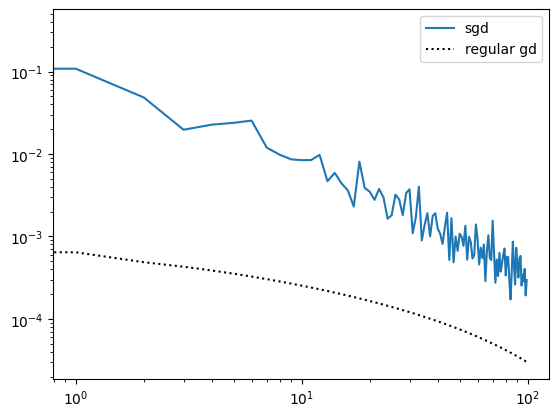

In [33]:
# plt.plot(alt_sol - opt_val, label="alt")
plt.plot(sgd_sol - opt_val, label="sgd")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

plt.loglog()
plt.legend()
plt.show()

In [34]:
def repeat_exec(base_model,
                model_arg,
                criterion,
                optimizer_class,
                dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                repeat_times=REPEAT_TIMES,
                lr=lr,
                lr_lambda=lr_one_t,
                l2=LAMBDA):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(
            clone_model(base_model, model_arg), 
            criterion,
            optimizer_class,
            dataloader,
            n_epoch,
            time_lim,
            verbose,
            lr,
            lr_lambda,
            l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [77]:
sgd_times, sgd_sols = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
)

Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


In [78]:
sgd_iid_times, sgd_sols_iid = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
)

Building models...


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


In [79]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cluster_dataloader,
)

Building models...


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


In [80]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cosine_dataloader,
)

Building models...


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


In [137]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [ ]:
# folder = "./saves/"
# exp_type = "MNIST_01_" #"MNIST_01_"
# bis = "(3)"
# ext = "b" + str(BATCH_SIZE) + bis + ".txt"

In [ ]:
# execution_res_names = ["sgd_sols_iid", "sgd_sols_cluster", "sgd_sols_cosine", "sgd_sols"]
# file_names = ["sgd_iid_", "sgd_clustered_", "cosine_", ""]

In [46]:
# for ref, name in zip(execution_res_names, file_names):
#     exec(ref + " = np.loadtxt(folder + exp_type + name + ext)")

In [ ]:
# for ref, name in zip(execution_res_names, file_names):
#     exec("np.savetxt('" + folder + exp_type + name + ext + "', np.array(" + ref + "))")

In [85]:
for losses in [sgd_sols_iid, sgd_sols_cluster, sgd_sols_cosine, sgd_sols]:
    for l in losses:
        opt_val = min(opt_val, min(l))
opt_val

0.000538667431101203

In [35]:
# cluster1 = new_cluster_sampler.clusters[0]
# restricted_data = clustered_data[cluster1]
# restricted_labels = full_labels[cluster1]
# wrong_model = SimpleModel(restricted_data)

# regularized_ls_new = []

# for i in tqdm(range(20000)):
#     reg_loss = get_regularized_loss(wrong_model, 
#                                     restricted_data, 
#                                     restricted_labels, 
#                                     log_01_criterion,
#                                     LAMBDA)
#     wrong_model.zero_grad()
#     reg_loss.backward()
#     for p in wrong_model.parameters():
#         p.data.sub_(lr*(p.grad.data))
#     regularized_ls_new.append(reg_loss.item())

# plt.plot(np.array(regularized_ls_new) - min(regularized_ls_new))
# plt.loglog()

# opt_wrong = get_regularized_loss(wrong_model, 
#                                     clustered_data, 
#                                     full_labels, 
#                                     log_01_criterion,
#                                     LAMBDA).item()
# opt_wrong

In [36]:
init_loss = get_regularized_loss(SimpleModel(clustered_data),
                                 clustered_data,
                                 full_labels,
                                 log_01_criterion,
                                 LAMBDA).item()
init_loss

0.6931473016738892

In [37]:
def plot_mult_iter(losses, opt_val, color, label, init_loss=init_loss):
    ls = np.array(losses)
    # because they all start at the init_loss
    # also the xscale on log removes the element 0
    ls = np.insert(ls, 0, init_loss, axis=1) 
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.3, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(np.arange(1, l+1), m-opt_val, color=color, label=label, alpha=0.9)
    # plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

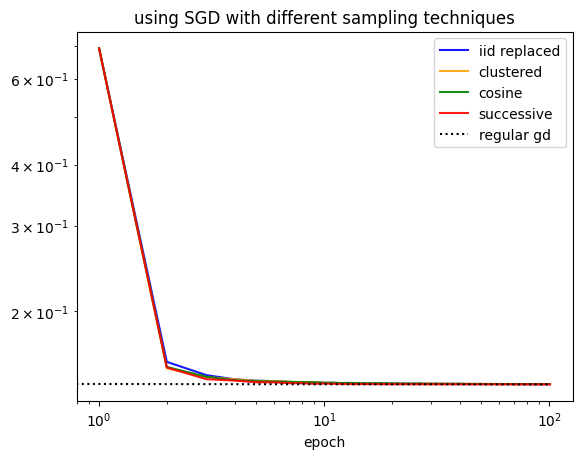

In [135]:
plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")


plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

What happens after reclustering?

In [38]:
lr_one_t_bis = lambda epoch: 5 / (epoch+1000)

In [39]:
sgd_bis_times, sgd_bis = repeat_exec(
    close_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
    lr_lambda=lr_one_t_bis,
)

Building models...


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Building models...


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Building models...


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


In [40]:
sgd_iid_bis_times, sgd_iid_bis = repeat_exec(
    close_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
    lr_lambda=lr_one_t_bis,
)

Building models...


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Building models...


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


In [41]:
sgd_rec_times, sgd_rec_bis = repeat_exec(
    close_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=new_cluster_dataloader,
    lr_lambda=lr_one_t_bis,
)

Building models...


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Building models...


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Building models...


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Building models...


100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Building models...


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Building models...


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


In [42]:
init_loss_bis = get_regularized_loss(close_model,
                                 clustered_data,
                                 full_labels,
                                 log_01_criterion,
                                 LAMBDA).item()
init_loss_bis

0.14444194734096527

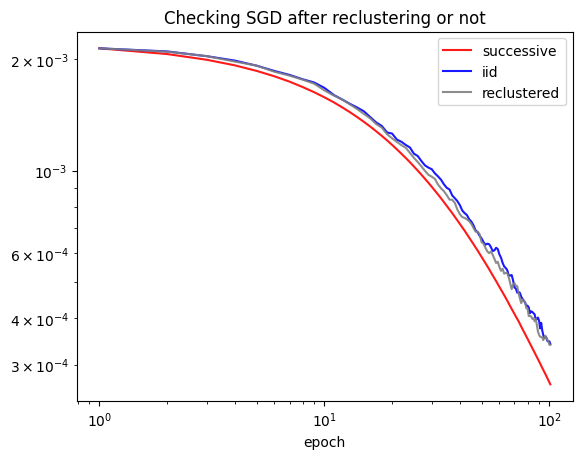

In [43]:
plot_mult_iter(sgd_bis, opt_val, color="red", label="successive", init_loss=init_loss_bis)
plot_mult_iter(sgd_iid_bis, opt_val, color="blue", label="iid", init_loss=init_loss_bis)
plot_mult_iter(sgd_rec_bis, opt_val, color="grey", label="reclustered", init_loss=init_loss_bis)

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("Checking SGD after reclustering or not")
plt.show()

In [60]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    n = len(dataset)
    
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], 
                    reduced[lims[i]:lims[i+1],1], 
                    alpha=0.5,
                    label="cluster size {}".format(len(cluster_sampler.clusters[i])))
    plt.legend()
    plt.title(title)
    plt.show()

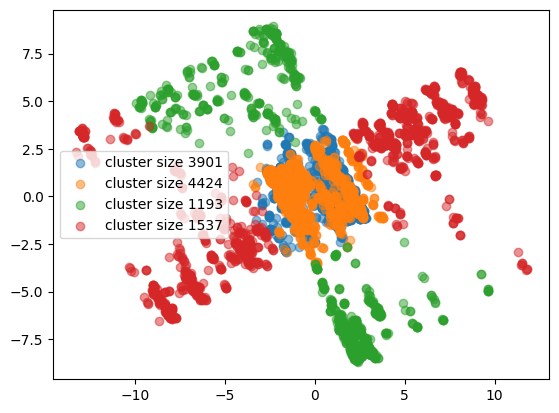

In [61]:
display_grads(dataset, SimpleModel(clustered_data), cluster_sampler)

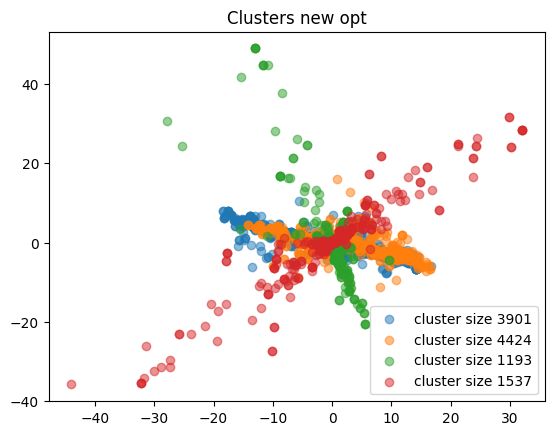

In [62]:
display_grads(dataset, model, cluster_sampler, title="Clusters new opt")

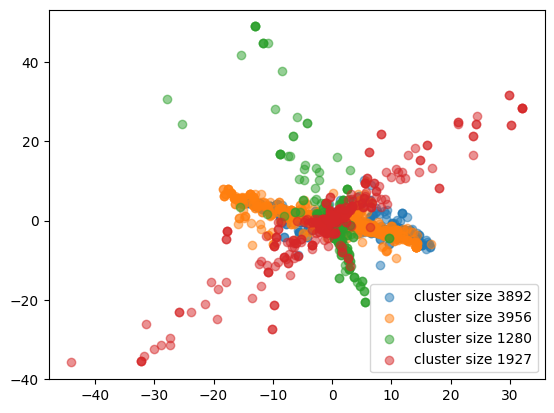

In [63]:
display_grads(dataset, model, cosine_cluster_sampler)

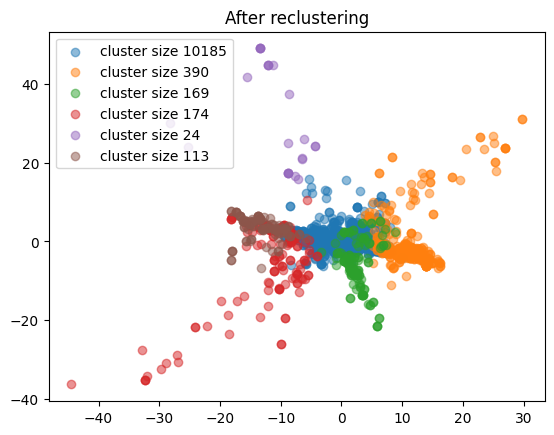

In [74]:
display_grads(dataset, close_model, new_cluster_sampler, title="After reclustering")

In [65]:
all_gradients = get_grad(clustered_data, full_labels, model)

In [ ]:
def alt_objective(clusters, all_gradients):
    # objective function associated with the alternative "kmeans"
    #  from https://arxiv.org/abs/1405.3080
    res = 0
    n = len(all_gradients)
    for cluster in clusters:
        grads = np.mean(all_gradients[cluster], axis=0)
        res += np.sqrt(len(cluster)*np.sum((all_gradients[cluster] - grads)**2))
    return res / (n**2)

print(alt_objective(alt_clusters, all_gradients))
print(alt_objective(cluster_sampler.clusters, all_gradients))

Calculating the variance at the optimum

In [66]:
from torch.utils.data import Sampler

# calculates the actual variance 
def batch_variance(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    grad = np.mean(batch_grads, axis=0)
    return np.mean(np.sum((batch_grads - grad)**2, axis=1))

full_dataset_var = batch_variance(clustered_data, full_labels, model)
print("full dataset variance:", full_dataset_var)

full dataset variance: 2.276589


In [67]:
def analyse_sampler(sampler:ClusterSampler, dataset:DataLoader, model, caption=None, verbose="full"):
    if verbose not in ["full", "short", "none"]:
        warnings.warn("verbose should be either 'full', 'short' or 'none'.")
    if caption is not None and verbose != "none":
        print(caption)
    batch_size = sum(sampler.sample_count) + sampler.added_count
    if verbose == "full":
        print("batch", batch_size, "added:", sampler.added_count)
    variances = np.zeros(sampler.cluster_count)
    for i, cluster in enumerate(sampler.clusters):
        batch, labels = dataset[cluster]
        variances[i] = batch_variance(batch, labels, model)
        if verbose == "full":
            print(sampler.cluster_sizes[i], 
                sampler.sample_count[i], 
                variances[i])
    avg = np.sum(variances*np.array(sampler.sample_count))/(batch_size - sampler.added_count)
    avg += sampler.added_count / sampler.num_samples * full_dataset_var
    if verbose == "full":
        print("average:", avg)
    elif verbose == "short":
        if caption is not None:
            print(caption, end=" ")
        print(avg)
    return avg

In [75]:
analyse_sampler(cluster_sampler, dataset, model, "Cluster variances")
analyse_sampler(cosine_cluster_sampler, dataset, model, "Cosine cluster variances")
analyse_sampler(new_cluster_sampler, dataset, model, "Recluster variances")

Cluster variances
batch 64 added: 3
3901 22 2.0457146167755127
4424 25 2.010942220687866
1193 6 2.5119636058807373
1537 8 3.4261116981506348
average: 2.25897767277304
Cosine cluster variances
batch 64 added: 2
3892 22 1.9900060892105103
3956 22 2.089294672012329
1280 7 2.614582061767578
1927 11 3.001586675643921
average: 2.2756400048208376
Recluster variances
batch 64 added: 3
10185 58 0.5631978511810303
390 2 15.877601623535156
169 0 9.716314315795898
174 1 21.111591339111328
24 0 33.86437225341797
113 0 17.164203643798828
average: 1.4027861588047443


1.4027861588047443

Why isn't the initial speed accelerated? Comparing variance

In [69]:
n_iter = 20

cluster_methods = [None, cluster_sampler, cosine_cluster_sampler, new_cluster_sampler]
variances = [np.zeros(n_iter) for _ in range(len(cluster_methods))]

test_model = SimpleModel(clustered_data)

for i in tqdm(range(n_iter)):
    for j, meth in enumerate(cluster_methods):
        if meth is None:
            variances[j][i] = batch_variance(clustered_data, full_labels, test_model)
        else:
            variances[j][i] = analyse_sampler(meth, dataset, test_model, verbose="none")

    reg_loss = get_regularized_loss(test_model, 
                                    clustered_data, 
                                    full_labels, 
                                    log_01_criterion,
                                    LAMBDA)
    test_model.zero_grad()
    reg_loss.backward()
    for p in test_model.parameters():
        p.data.sub_(lr*(p.grad.data))


100%|██████████| 20/20 [03:47<00:00, 11.39s/it]


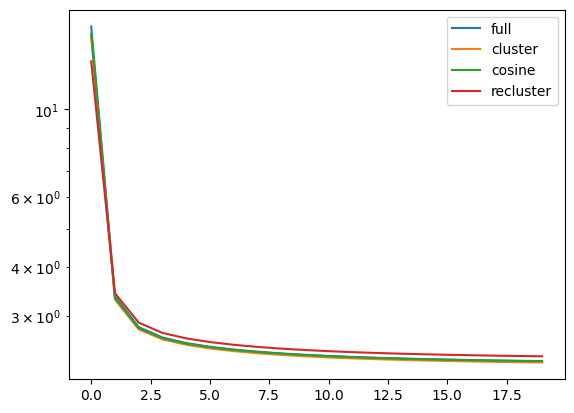

In [70]:
plot_labels = ["full", "cluster", "cosine", "recluster"]
for v, l in zip(variances, plot_labels):
    plt.plot(v, label=l)
plt.legend()
plt.yscale("log")
plt.show()

In [71]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)

Is the variance the problem?

Note that if the variance is really negligible then convergence should look like regular gradient descent

In [51]:
def batch_sq_mean(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    return np.mean(np.sum(batch_grads**2, axis=1))

In [52]:
from torch.optim.lr_scheduler import LambdaLR

EXP_NB_EPOCH = 80
EXP_BATCH_SIZE = 64

m_gd = SimpleModel(clustered_data)
m_sgd = SimpleModel(clustered_data)

optim_gd = torch.optim.SGD(m_gd.parameters(), lr=lr, weight_decay=LAMBDA)
schedul_gd = LambdaLR(optim_gd, lr_lambda=lr_one_t)

optim_sgd = torch.optim.SGD(m_sgd.parameters(), lr=lr, weight_decay=LAMBDA)
schedul_sgd = LambdaLR(optim_sgd, lr_lambda=lr_one_t)
loader = DataLoader(dataset, batch_size=EXP_BATCH_SIZE, sampler=iid_sampler)

gd_losses = []
sgd_losses = []
var_over_time = []

for epoch in tqdm(range(EXP_NB_EPOCH)):
    for (batch, labels) in loader:
        # matching the number of iterations for full batch
        pred1 = m_gd(clustered_data)
        l1 = log_01_criterion(pred1, full_labels)
        optim_gd.zero_grad()
        l1.backward()
        optim_gd.step()
        # batches
        pred2 = m_sgd(batch)
        l2 = log_01_criterion(pred2, labels)
        optim_sgd.zero_grad()
        l2.backward()
        optim_sgd.step()
    variance = batch_variance(clustered_data, full_labels, m_sgd)/EXP_BATCH_SIZE #batch_sq_mean(clustered_data, full_labels, m_sgd)
    
    schedul_gd.step()
    gd_losses.append(get_regularized_loss(m_gd, 
                                          clustered_data, 
                                          full_labels,
                                          log_01_criterion,
                                          LAMBDA).item())

    schedul_sgd.step()
    var_over_time.append(variance)
    sgd_losses.append(get_regularized_loss(m_sgd, 
                                           clustered_data, 
                                           full_labels,
                                           log_01_criterion,
                                           LAMBDA).item())


100%|██████████| 80/80 [04:12<00:00,  3.16s/it]


In [53]:
opt_val = min(opt_val, min(gd_losses))

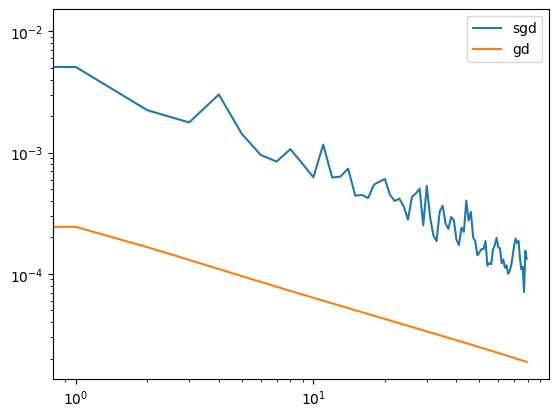

In [54]:
plt.plot(np.array(sgd_losses)-opt_val, label="sgd")
plt.plot(np.array(gd_losses)-opt_val, label="gd")
plt.legend()
plt.loglog()
plt.show()

In [55]:
model_norm = 0
for p in model.parameters():
    model_norm += (p.data**2).sum()
model_norm = model_norm.item()
model_norm

12.331050872802734

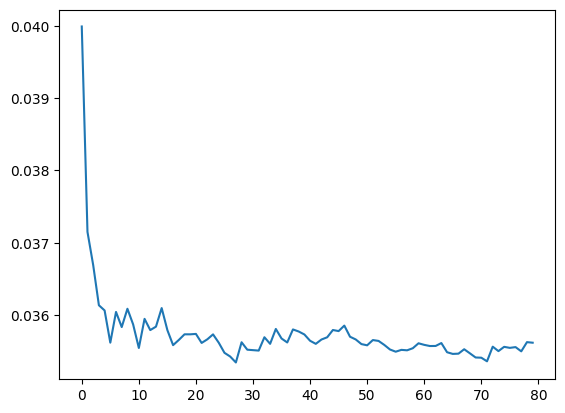

In [56]:
plt.plot(var_over_time)

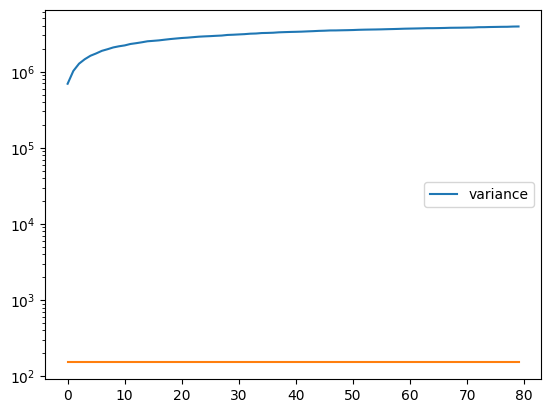

In [59]:
linspace = np.arange(EXP_NB_EPOCH)

plt.plot(np.log(linspace+2)*var_over_time/(2*LAMBDA)**2, label="variance")
plt.plot([model_norm**2]*EXP_NB_EPOCH)
plt.yscale("log")
plt.legend()
plt.show()

For visualisation purposes when 2 dimensions

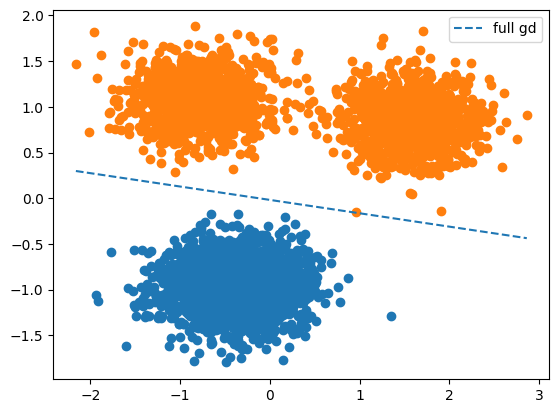

In [61]:
def plot_decision_boundary(data, model, label=None):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, '--', label=label)
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', label=label)

plot_decision_boundary(clustered_data, model, "full gd")
# plot_decision_boundary(clustered_data, test_m, "test")

plt.scatter(clustered_data[mask_0, 0], clustered_data[mask_0, 1])
plt.scatter(clustered_data[mask_1, 0], clustered_data[mask_1, 1])
plt.legend()
plt.show()

Testing sampler speed to seek for improvement

In [32]:
def test_sampler_speed(sampler):
    ITER_COUNT = 10
    dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler)
    begin = time.perf_counter()
    for i in range(ITER_COUNT):
        for (batch, labels) in dataloader:
            pass
    end = time.perf_counter()
    print((end - begin)/ITER_COUNT)

In [ ]:
test_sampler_speed(None)
test_sampler_speed(RandomSampler(dataset))
test_sampler_speed(ClusterSampler(dataset, BATCH_SIZE, logistic_label_01_process))

0.1565863200000422
